In this example we show how the model hub can be used to get the contribution of features to reaching conversion. With the model hub, you can estimate the contribution, as well as evaluate the model performance. 

In [1]:
from modelhub import ModelHub
from matplotlib import pyplot as plt

In [2]:
# instantiate the model hub
modelhub = ModelHub(time_aggregation='YYYY-MM-DD')
# get the Bach DataFrame with Objectiv data
df = modelhub.get_objectiv_dataframe(start_date='2022-02-01')

In [3]:
df.head()

,day,moment,user_id,global_contexts,location_stack,event_type,stack_event_types,session_id,session_hit_number
event_id,,,,,,,,,
d4a0cb80-729c-4e17-9a42-6cb48672250f,2022-03-15,2022-03-15 08:36:33.123,005aa19c-7e80-4960-928c-a0853355ee5f,"[{'id': 'http_context', '_type': 'HttpContext'...","[{'id': 'about', '_type': 'RootLocationContext...",PressEvent,"[AbstractEvent, InteractiveEvent, PressEvent]",1351,1
75afa7bc-5237-4033-a833-bf9e0e85a3c1,2022-03-15,2022-03-15 08:36:44.625,005aa19c-7e80-4960-928c-a0853355ee5f,"[{'id': 'http_context', '_type': 'HttpContext'...","[{'id': 'about', '_type': 'RootLocationContext...",PressEvent,"[AbstractEvent, InteractiveEvent, PressEvent]",1351,2
b232b68d-8494-4b9e-abeb-d1ef2e945039,2022-02-07,2022-02-07 08:36:19.809,009f4da5-774b-4e10-b2b6-d3d66e3bd08b,"[{'id': 'objectiv-website', '_type': 'Applicat...","[{'id': 'blog', '_type': 'RootLocationContext'...",PressEvent,"[AbstractEvent, InteractiveEvent, PressEvent]",540,1
2865beed-f191-467a-9359-7f1d858f6638,2022-04-14,2022-04-14 21:17:36.140,00b011eb-74ee-4d01-a00f-36617c6a0ee1,"[{'id': 'http_context', '_type': 'HttpContext'...","[{'id': 'home', '_type': 'RootLocationContext'...",ApplicationLoadedEvent,"[AbstractEvent, ApplicationLoadedEvent, NonInt...",1775,1
ed3f8d66-c354-4a4e-8714-2ff9db0d51a5,2022-04-14,2022-04-14 21:17:36.157,00b011eb-74ee-4d01-a00f-36617c6a0ee1,"[{'id': 'http_context', '_type': 'HttpContext'...","[{'id': 'home', '_type': 'RootLocationContext'...",VisibleEvent,"[AbstractEvent, NonInteractiveEvent, VisibleEv...",1775,2


In [4]:
# define which events to use as conversion events
modelhub.add_conversion_event(location_stack=df.location_stack.json[{'id': 'objectiv-on-github', 
                                                                     '_type': 'LinkContext'}:].fillna(
                                             df.location_stack.json[{'id': 'github', '_type': 'LinkContext'}:]),
                              event_type='PressEvent',
                              name='github_press')

In [5]:
df['root'] = df.location_stack.ls.get_from_context_with_type_series(type='RootLocationContext', key='id')

We want to obtain the impact of pressing in individual sections (root location) on our website. We assume a true causal relation between the number of clicks per root location and conversion. Make sure to think of this assumption when using this model on your own data. Therefore we estimate conversion by the number of presses in each root location on our site per user using a logistic regression model. The coefficients of this regression can be interpreted as the contribution to conversion (direction and magnitude). 

The feature importance model returns a trained model, but also the data sets that is used for training the model based on the parameters. 

This let's you adjust the data set further or use the model as is.

The model has methods for the accuracy assesment.

#### todo 

model should be a class that allows for rerunning the data on a cleaned data set. currently just a dict with results.

In [6]:
X_temp, y_temp, model = modelhub.agg.feature_importance(
    data=df[df.event_type=='PressEvent'],
    name='github_press',
    feature_column='root'
)

In [7]:
y_temp

In [8]:
y_temp.head()

user_id
3c5a5bb8-e855-4bd2-9011-e0604bc60ad3     True
30ea7fc7-7dbe-4080-b980-55120503479d     True
e78fe4d7-ce68-4e8c-b284-4a52010547db    False
bc5cca28-a860-402f-a482-38f78f8305e2    False
a8409691-e826-4639-8ee2-aca9115a6f44     True
Name: is_converted, dtype: bool

In [9]:
X_temp

In [10]:
X_temp.head()

,about,blog,docs,home,jobs,join-slack,modeling,privacy,taxonomy,tracking
user_id,,,,,,,,,,
3c5a5bb8-e855-4bd2-9011-e0604bc60ad3,0,2,0,12,0,0,2,0,0,0
30ea7fc7-7dbe-4080-b980-55120503479d,12,10,0,25,2,0,3,0,7,4
e78fe4d7-ce68-4e8c-b284-4a52010547db,1,0,0,5,1,0,1,0,0,0
bc5cca28-a860-402f-a482-38f78f8305e2,2,23,50,52,0,0,19,0,17,12
a8409691-e826-4639-8ee2-aca9115a6f44,13,6,2,48,0,0,10,0,3,1


In our example, we will go into detailed assessment of the model's accuracy, so we won't jumpt to the model results, but instead first look at our data set and prepare a proper data set for the model.

In [11]:
data_set_temp = X_temp.copy()
data_set_temp['is_converted'] = y_temp
# todo sum axis = 1? now gets all user ids
data_set_temp['total_press'] = X_temp.stack().to_frame().reset_index().groupby('user_id').__stacked.sum().to_pandas()

### Review the dataset

First the data set has to be prepared. The data set and the relation between predictors and the predicted classes have to fulfill several assumptions, such as there are sample size, linearity between features and log odds and no influential outliers. We look at our data to try to get the best possible data set for the model`


In [12]:
data_set_temp.describe().head()

,about,blog,docs,home,jobs,join-slack,modeling,privacy,taxonomy,tracking,total_press
__stat,,,,,,,,,,,
count,579.00,579.00,579.0,579.00,579.00,579.00,579.00,579.00,579.0,579.00,579.00
mean,0.46,0.61,0.9,2.41,0.31,0.00,0.62,0.00,0.3,0.53,6.13
std,1.17,1.51,7.3,5.02,0.96,0.04,4.12,0.04,1.5,3.06,16.10
min,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.00
max,13.00,23.00,146.0,56.00,12.00,1.00,80.00,1.00,17.0,33.00,213.00


In [13]:
data_set_temp.is_converted.value_counts().head()

is_converted
False    509
True      70
Name: value_counts, dtype: int64

In [14]:
(data_set_temp.is_converted.value_counts()/data_set_temp.is_converted.count()).head()

is_converted
False    0.879102
True     0.120898
Name: value_counts, dtype: float64

We see most variables have a mean of less than zero. We can also look at the distributions of the variables. We split the histograms for each variable by conversion.

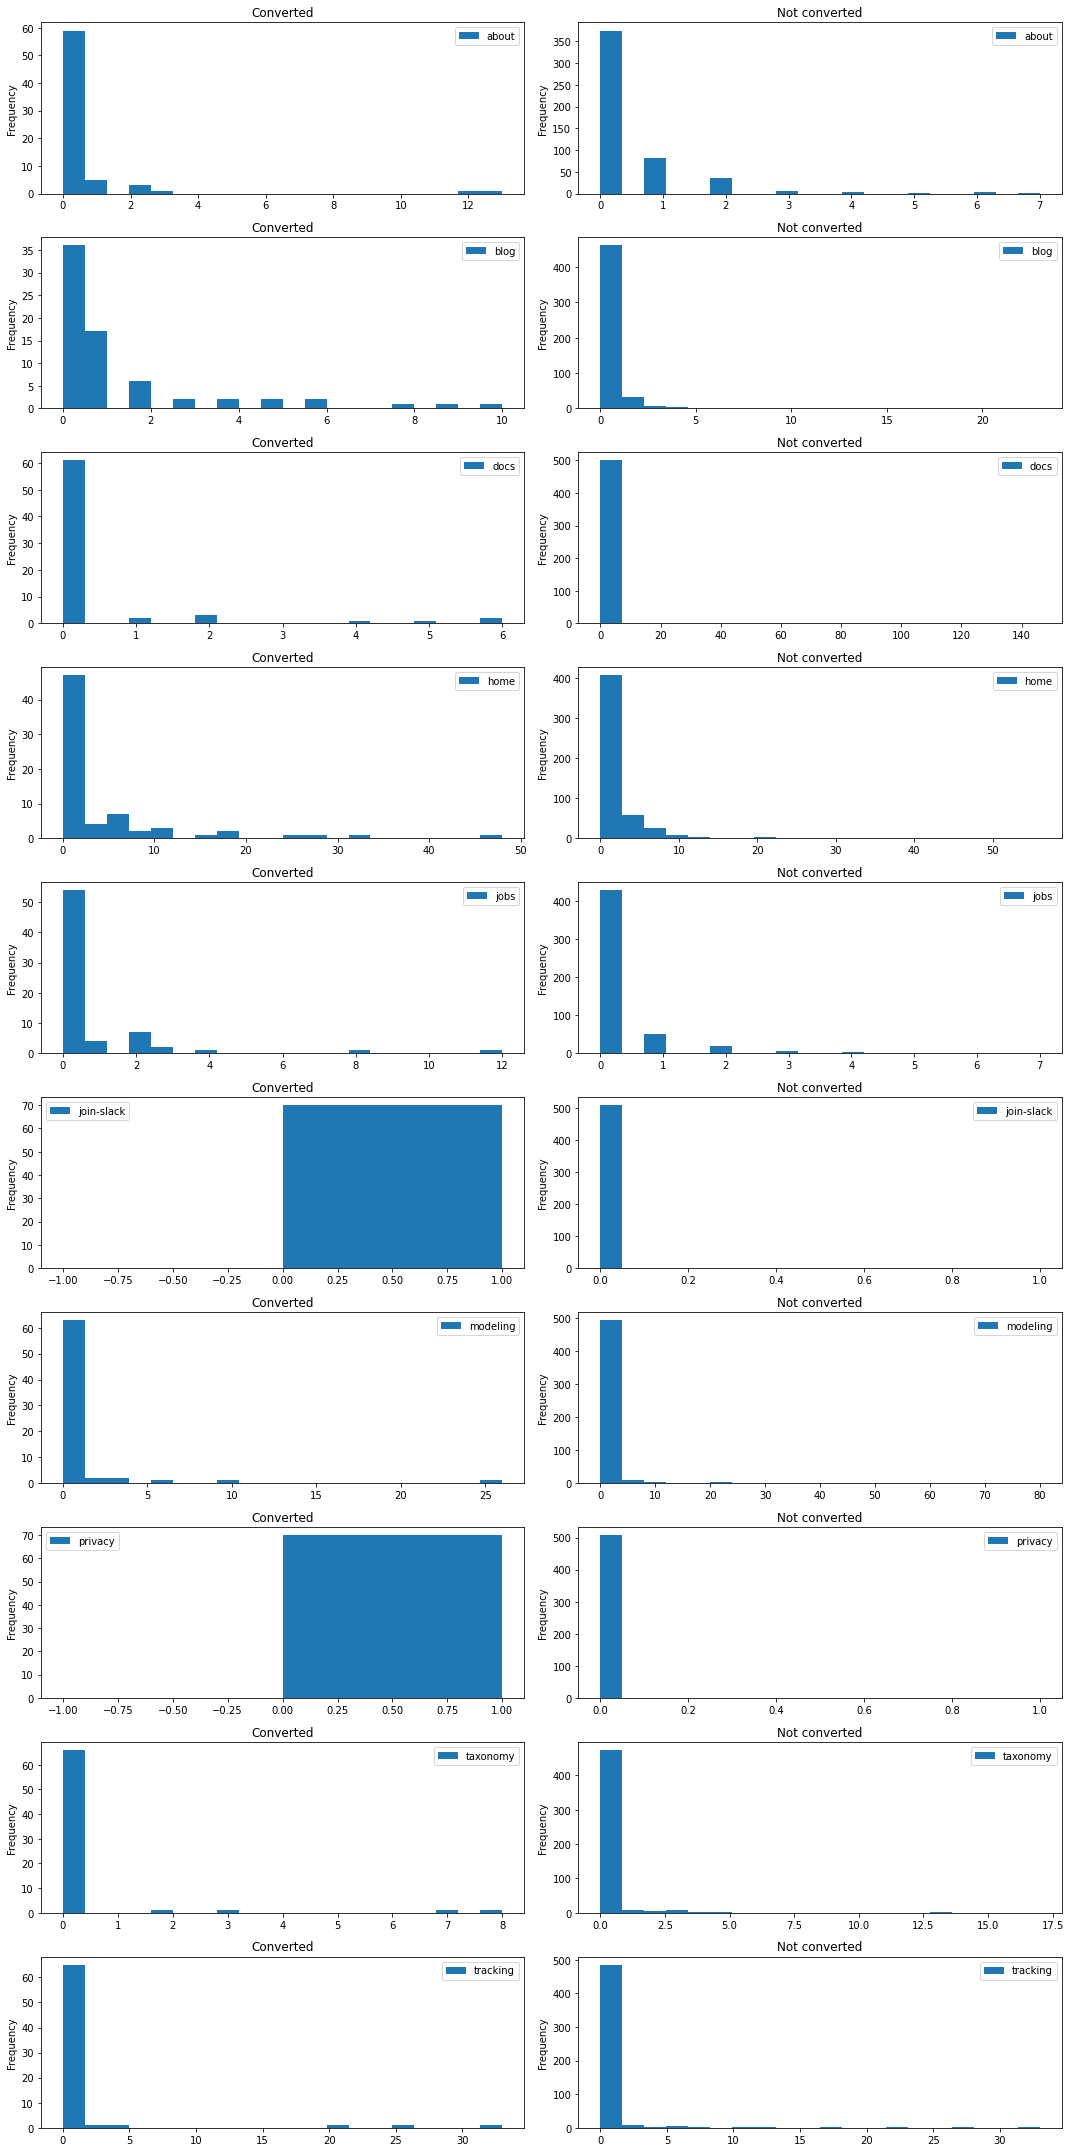

In [15]:
figure, axis = plt.subplots(len(X_temp.data_columns), 2, figsize=(15,30))

for idx, name in enumerate(X_temp.data_columns):
    data_set_temp[data_set_temp.is_converted==True][[name]].plot.hist(bins=20, title='Converted', ax=axis[idx][0])
    data_set_temp[data_set_temp.is_converted==False][[name]].plot.hist(bins=20, title='Not converted', ax=axis[idx][1])
plt.tight_layout()

To make this problem less, we first drop two variables that have (almost) no distribution at all: privacy and join slack.

In [16]:
data_set_temp = data_set_temp.drop(columns=['privacy','join-slack'])
columns_remaining = [x for x in data_set_temp.data_columns if x in X_temp.data_columns]

Also, to unskew the data, we drop all users that have visited only one page, as we believe that such cases don't have any explanatory power to the target (it means reaching the goal after one click). 

Those might, for instance, be users that wanted to go to our github, and this was the quickest way to get there with the results Google provided them. In that case, the intent of the user (something of which we can never be sure), was going to the github page. The features did not convince them. 

By filtering like this, it is more likely that the used features on our website did, or did not convince a user to check out our product on github. This is exactly what we are after.

In [17]:
data_set_temp = data_set_temp[data_set_temp.total_press>1]

In [18]:
data_set_temp.describe().head()

,about,blog,docs,home,jobs,modeling,taxonomy,tracking,total_press
__stat,,,,,,,,,
count,362.00,362.00,362.00,362.00,362.00,362.00,362.00,362.00,362.00
mean,0.70,0.81,1.43,3.48,0.48,0.98,0.48,0.84,9.21
std,1.42,1.86,9.19,6.09,1.18,5.18,1.88,3.84,19.75
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
max,13.00,23.00,146.00,56.00,12.00,80.00,17.00,33.00,213.00


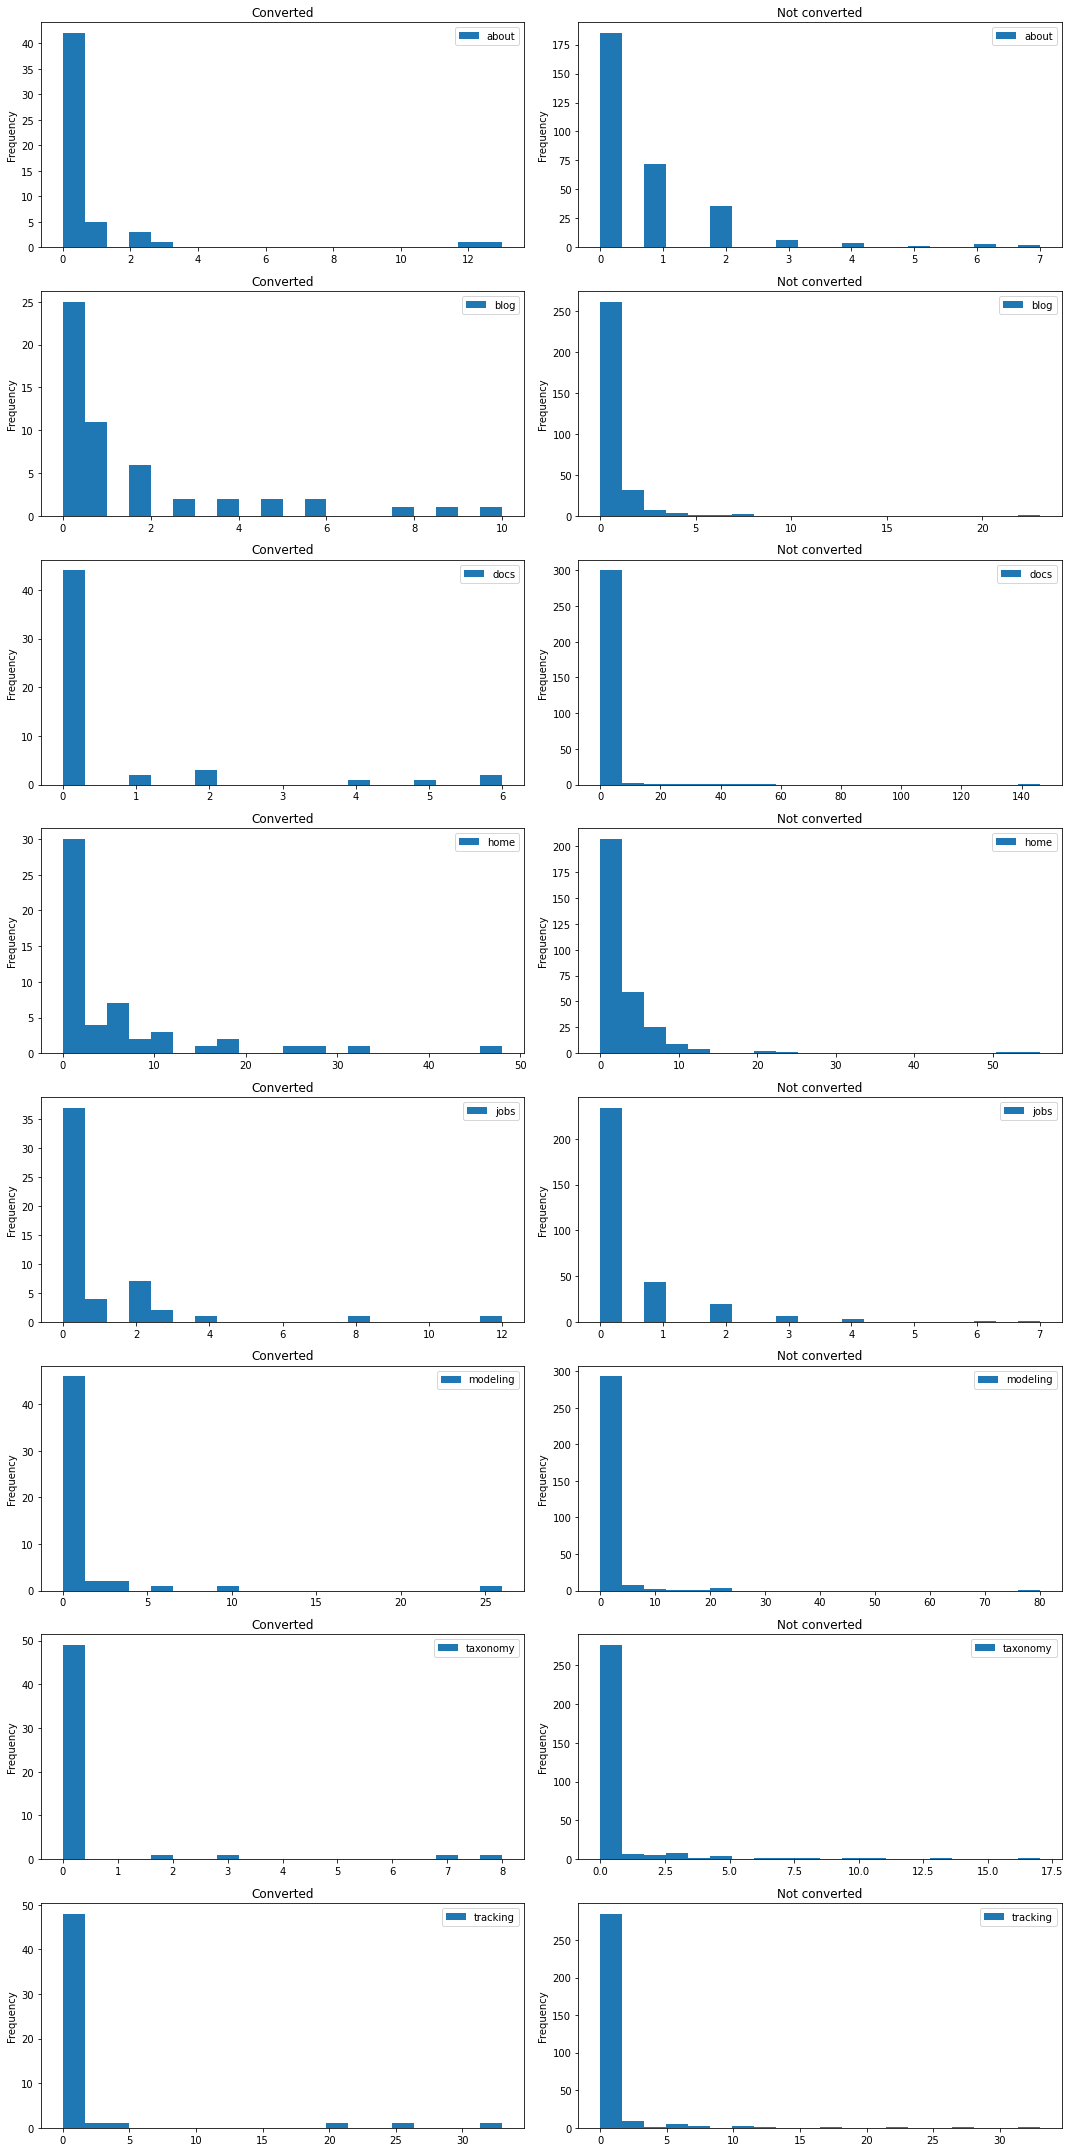

In [19]:
figure, axis = plt.subplots(len(columns_remaining), 2, figsize=(15,30))

for idx, name in enumerate(columns_remaining):
    data_set_temp[data_set_temp.is_converted==True][[name]].plot.hist(bins=20, title='Converted', ax=axis[idx][0])
    data_set_temp[data_set_temp.is_converted==False][[name]].plot.hist(bins=20, title='Not converted', ax=axis[idx][1])
plt.tight_layout()

Although our feature usage is still skewed, with many users using a feature 0 times, it is better than before. The data set is also smaller, but (slgihtly) more balanced. This can be seen from the (in most cases) higher mean and std as well as the plots.

In [20]:
data_set_temp.is_converted.value_counts().head()

is_converted
False    309
True      53
Name: value_counts, dtype: int64

In [21]:
(data_set_temp.is_converted.value_counts()/data_set_temp.is_converted.count()).head()

is_converted
False    0.853591
True     0.146409
Name: value_counts, dtype: float64

In [22]:
data_set = data_set_temp[columns_remaining+['is_converted']]
X = data_set[columns_remaining]
y = data_set.is_converted

## Model

The model of choice is a logistic regression. This model gives a probablity of converting and also lets us interpret the feature coefficients, which is key to our goal.

#### Error metric

We choose the error metric. Not overall f1 score, becasue we have an imbalanced dataset. So we look at predicting conversions in particular, while keeping in mind that overall accuracy shouldnt drop too much.

One way is to balance data set, but we don't cause we want to use all data.

The most important measure of model goodness is AUC. The reason is that we are not so much interested in the actual predicted label, as we are interested in the coefficients of the model. The AUC can then give a good indication of performance compared to a baseline.



The 'feature_importance_proto' model splits the data in three parts and runs the model in three folds. The results is based on the average of the coeficients of the three runs. The AUC for each model is averaged and interpreted as model goodness.

In [23]:
model.fit(X, y, seed=.4)

In [24]:
model.results()

,mean,std
about,-0.527056,0.187823
taxonomy,-0.382087,0.408441
modeling,-0.177952,0.138875
docs,-0.153020,0.068133
tracking,0.062448,0.020743
home,0.208223,0.028553
jobs,0.379888,0.121377
blog,0.492551,0.123766


The average of the AUC on the three test sets indicates an ok performance. Therefore the coefficients can be interpreted as giving some explanation to predicting conversion.

In [25]:
model.results()

,mean,std
about,-0.527056,0.187823
taxonomy,-0.382087,0.408441
modeling,-0.177952,0.138875
docs,-0.153020,0.068133
tracking,0.062448,0.020743
home,0.208223,0.028553
jobs,0.379888,0.121377
blog,0.492551,0.123766


In [26]:
model.results(full=True)

,about,blog,docs,home,jobs,modeling,taxonomy,tracking
0,-0.716767,0.597797,-0.151692,0.181995,0.35433,-0.161922,0.020103,0.038694
0,-0.34118,0.356199,-0.221807,0.204036,0.512009,-0.047788,-0.369859,0.07167
0,-0.523219,0.523655,-0.08556,0.238639,0.273325,-0.324147,-0.796505,0.076982


The average feature coeficient, for most features is, quite stable and has the same sign for all runs, tested solely on unseen data for model training. The lower the standard deviation, the more stable the coefficient is in the different training runs. Do note that 1/2 of every training set contains the same data.